<a href="https://colab.research.google.com/github/AUT-Student/NN-HW2/blob/main/NN_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Datasets

In [8]:
class Dataset():
  def __init__(self, dataset_type):
    if dataset_type == "LinearSeprable":
      self._create_ls_dataset()
    elif dataset_type == "XOR":
      self._create_xor_dataset()

    self._shuffle_and_split()

  def _create_ls_dataset(self):
    cov = [[1, 0], [0, 1]]

    mean_0 = [0,0]
    mean_1 = [10,10]

    number_data_per_class = 5000    

    data_0 = pd.DataFrame(np.random.multivariate_normal(mean_0, cov, number_data_per_class), columns=["X1", "X2"])
    data_0["Y"] = [-1] * number_data_per_class 

    data_1 = pd.DataFrame(np.random.multivariate_normal(mean_1, cov, number_data_per_class), columns=["X1", "X2"])
    data_1["Y"] = [+1] * number_data_per_class

    self.data = pd.concat([data_0, data_1], ignore_index= True)

  def _create_xor_dataset(self):
    cov = [[1, 0], [0, 1]]

    mean_00 = [0, 0]
    mean_01 = [0, 10] 
    mean_10 = [10, 0] 
    mean_11 = [10, 10] 

    number_data_per_part = 2500

    number_data_per_part = 2500

    data_00 = pd.DataFrame(np.random.multivariate_normal(mean_00, cov, number_data_per_part), columns=["X1", "X2"])
    data_00["Y"] = [-1] * number_data_per_part 

    data_11 = pd.DataFrame(np.random.multivariate_normal(mean_11, cov, number_data_per_part), columns=["X1", "X2"])
    data_11["Y"] = [-1] * number_data_per_part 

    data_01 = pd.DataFrame(np.random.multivariate_normal(mean_01, cov, number_data_per_part), columns=["X1", "X2"])
    data_01["Y"] = [+1] * number_data_per_part 

    data_10 = pd.DataFrame(np.random.multivariate_normal(mean_10, cov, number_data_per_part), columns=["X1", "X2"])
    data_10["Y"] = [+1] * number_data_per_part 

    self.data = pd.concat([data_00, data_01, data_10, data_11], ignore_index= True)


  def _shuffle_and_split(self):
    self.data = self.data.sample(frac=1).reset_index()

    # 70% train, 10% validation, 20% test
    self.train_data = self.data[:7000]
    self.validation_data = self.data[7000:8000]
    self.test_data = self.data[8000:]

  def plot_dataset(self):
    plt.scatter(self.data[self.data["Y"]==-1]["X1"], self.data[self.data["Y"]==-1]["X2"], label="Class -", c="red")
    plt.scatter(self.data[self.data["Y"]==+1]["X1"], self.data[self.data["Y"]==+1]["X2"], label="Class +", c="green")

    plt.legend()
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Dataset Overview")
    plt.show()

  def X_train(self):
    return self.train_data[["X1", "X2"]].values

  def Y_train(self):
    return self.train_data["Y"].values

  def X_validation(self):
    return self.validation_data[["X1", "X2"]].values

  def Y_validation(self):
    return self.validation_data["Y"].values

  def X_test(self):
    return self.test_data[["X1", "X2"]].values

  def Y_test(self):
    return self.test_data["Y"].values

  def train(self):
    return self.train_data

  def validation(self):
    return self.validation_data

  def test(self):
    return self.test_data

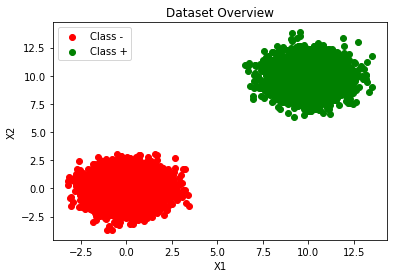

In [9]:
ls_dataset = Dataset("LinearSeprable")
ls_dataset.plot_dataset()

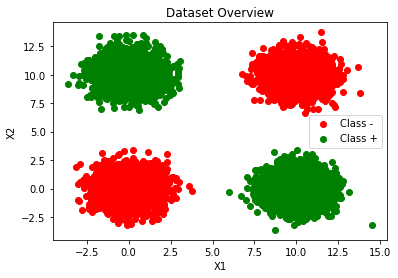

In [10]:
xor_dataset = Dataset("XOR")
xor_dataset.plot_dataset()

# Activation Functions

In [33]:
class ActivationFunctions():
  @staticmethod
  def bipolar_sigmoid(x):
    return (1 - math.exp(-x)) / (1 + math.exp(-x))

  @staticmethod
  def identity(x):
    return x

  @staticmethod
  def sign(x):
    if x>= 0:
      return +1
    else:
      return -1

  @staticmethod
  def generate_step(t):
    def step(x):
      if x >= t:
        return +1
      else:
        return -1
    
    return step

  @staticmethod
  def tanh(x):
    return np.tanh(x)

# Perceptron

In [22]:
class Perceptron():
  def __init__(self, alpha, activation_function, degree=1):
    self.alpha = alpha
    self.activation_function = activation_function
    self.error_values = []
    self.degree = degree

    if self.degree == 1:
      self.w = np.random.uniform(low=-1, high=+1, size=(3,))
    elif self.degree == 2:
      self.w = np.random.uniform(low=-1, high=+1, size=(5,))
   
  def complete_X(self, X):
    if self.degree == 1:
      return np.concatenate(([1], X))
    elif self.degree == 2:
      return np.array([1, X[0], X[1], X[0]**2, X[1]**2])

  def predict(self, X):
    I = self.w @ self.complete_X(X)
    y = self.activation_function(I)
    return y

  def error(self, X, t):
    sum = 0
    for i in range(len(t)):
      sum += np.abs(self.predict(X[i]) - t[i])
    return sum/(2*len(t))

  def accuracy(self, X, t):
    number_true = 0
    for i in range(len(t)):
      if self.predict(X[i])==t[i]:
        number_true += 1
    
    return number_true/len(t)

  def train_sample(self, X, t):
    y = self.predict(X)
    self.w = self.w + self.alpha * (t-y) * self.complete_X(X)

  def train(self, X_train, y_train, X_validation, y_validation, epochs):
    for epoch in range(epochs):
      for i in range(len(X_train)):
        self.train_sample(X_train[i], y_train[i])

        if (i+1)%1000 == 0:
          self.error_values.append(
              {"i": epoch*len(X_train) + i,
               "train": self.error(X_train, y_train),
               "validation": self.error(X_validation, y_validation)
               })
    
  def show_error_values(self):
    i_list = []
    train_error_list = []
    validation_error_list = []

    for item in self.error_values:
      i_list.append(item["i"])
      train_error_list.append(item["train"])
      validation_error_list.append(item["validation"])
    
    plt.scatter(i_list, train_error_list, c="blue", label="Train Error", alpha=0.5)
    plt.plot(i_list, train_error_list, c="blue", alpha=0.5)
    plt.scatter(i_list, validation_error_list, c="red", label="Validation Error", alpha=0.5)
    plt.plot(i_list, validation_error_list, c="red", alpha=0.5)

    plt.legend()
    plt.xlabel("Number Trained Data")
    plt.ylabel("Error")
    plt.title("Error Changes in Training of the Perceptron")
    plt.show()

    print(f"Train Accuracy = {self.accuracy(ls_dataset.X_train(), ls_dataset.Y_train())}")
    print(f"Validation Accuracy = {self.accuracy(ls_dataset.X_validation(), ls_dataset.Y_validation())}")


  def show_decision_boundry(self, dataset):
    plt.scatter(dataset[dataset["Y"]==-1]["X1"], dataset[dataset["Y"]==-1]["X2"], label="Class -", c="red")
    plt.scatter(dataset[dataset["Y"]==+1]["X1"], dataset[dataset["Y"]==+1]["X2"], label="Class +", c="green")

    x = np.linspace(-4, 14, 1000)

    if self.degree == 1:
      plt.plot(x, (-self.w[1]/self.w[2]*x)-self.w[0]/self.w[2], label="Decision Boundry", c="blue")

    elif self.degree == 2:
      w0, w1, w2, w3, w4 = self.w
      plt.plot(x, -w2/w4 + np.sqrt(-w0/w4-w1/w4*x-w3/w4*x**2-(w2/w4)**2) , label="Decision Boundry", c="blue")
      plt.plot(x, -w2/w4 - np.sqrt(-w0/w4-w1/w4*x-w3/w4*x**2-(w2/w4)**2), c="blue")

    plt.legend()
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Perceptron Decision Boundary")
    plt.show()      

# Adaline

In [23]:
class Adaline():
  def __init__(self, alpha, activation_function, degree=1):
    self.alpha = alpha
    self.activation_function = activation_function
    self.error_values = []
    self.degree = degree

    if self.degree == 1:
      self.w = np.random.uniform(low=-1, high=+1, size=(3,))
    elif self.degree == 2:
      self.w = np.random.uniform(low=-1, high=+1, size=(6,))

  def error(self, X, t):
    sum = 0
    for i in range(len(t)):
      sum += (self.linear_output(X[i]) - t[i])**2
    return sum/(len(t))

  def accuracy(self, X, t):
    number_true = 0
    for i in range(len(t)):
      if self.predict(X[i])==t[i]:
        number_true += 1
    
    return number_true/len(t)

  def complete_X(self, X):
    if self.degree == 1:
      return np.concatenate(([1], X))
    elif self.degree == 2:
      return np.array([1, X[0], X[1], X[0]**2, X[1]**2, X[0]*X[1]])

  def linear_output(self, X):
    I = self.w @ self.complete_X(X)
    y = self.activation_function(I)
    return y

  def bipolar_output(self, X):
    return np.sign(self.linear_output(X))

  def predict(self, X):
    return self.bipolar_output(X)

  def train_sample(self, X, t):
    y = self.linear_output(X)
    self.w = self.w + self.alpha * (t-y) * self.complete_X(X)

  def train(self, X_train, y_train, X_validation, y_validation, epochs):
    for epoch in range(epochs):
      for i in range(len(X_train)):
        self.train_sample(X_train[i], y_train[i])

        if (i+1)%1000 == 0:
          self.error_values.append(
              {"i": epoch*len(X_train) + i,
               "train": self.error(X_train, y_train),
               "validation": self.error(X_validation, y_validation)
               })

  def show_error_values(self):
    i_list = []
    train_error_list = []
    validation_error_list = []

    for item in self.error_values:
      i_list.append(item["i"])
      train_error_list.append(item["train"])
      validation_error_list.append(item["validation"])
    
    plt.scatter(i_list, train_error_list, c="blue", label="Train Error", alpha=0.5)
    plt.plot(i_list, train_error_list, c="blue", alpha=0.5)
    plt.scatter(i_list, validation_error_list, c="red", label="Validation Error", alpha=0.5)
    plt.plot(i_list, validation_error_list, c="red", alpha=0.5)

    plt.legend()
    plt.xlabel("Number Trained Data")
    plt.ylabel("Error")
    plt.title("Error Changes in Training of the Adaline")
    plt.show()

    print(f"Train Accuracy = {self.accuracy(ls_dataset.X_train(), ls_dataset.Y_train())}")
    print(f"Validation Accuracy = {self.accuracy(ls_dataset.X_validation(), ls_dataset.Y_validation())}")

  def show_decision_boundry(self, dataset):
    if self.degree == 1:
      plt.scatter(dataset[dataset["Y"]==-1]["X1"], dataset[dataset["Y"]==-1]["X2"], label="Class -", c="red")
      plt.scatter(dataset[dataset["Y"]==+1]["X1"], dataset[dataset["Y"]==+1]["X2"], label="Class +", c="green")

      x = np.linspace(-4, 12, 1000)
      plt.plot(x, (-self.w[1]/self.w[2]*x)-self.w[0]/self.w[2], label="Decision Boundry", c="blue")

      plt.legend()
      plt.xlabel("X1")
      plt.ylabel("X2")
      plt.title("Adaline Decision Boundary")
      plt.show()    

# Expriments (Part 3)

## Perceptron

### Learning Rate


alpha = 1e-05


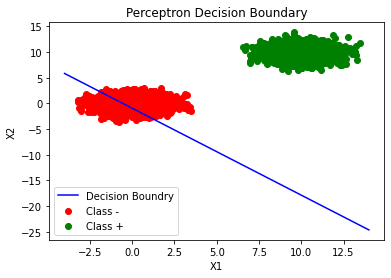

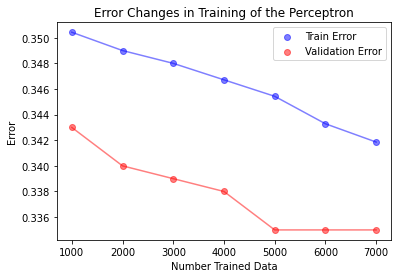

Train Accuracy = 0.6581428571428571
Validation Accuracy = 0.665

alpha = 0.01


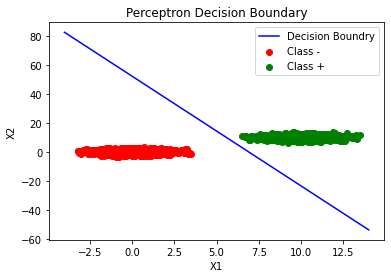

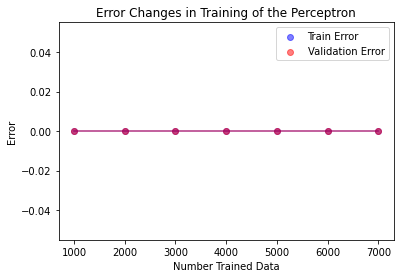

Train Accuracy = 1.0
Validation Accuracy = 1.0

alpha = 0.1


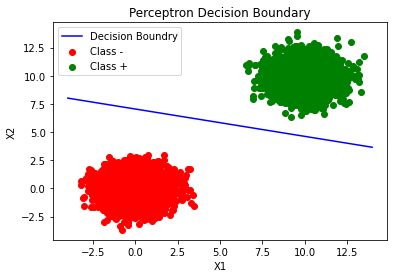

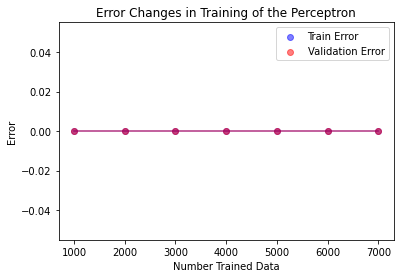

Train Accuracy = 1.0
Validation Accuracy = 1.0

alpha = 1


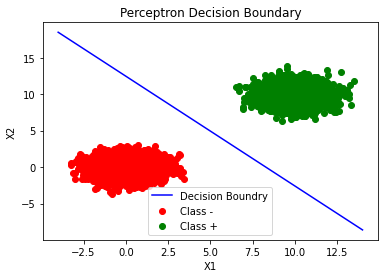

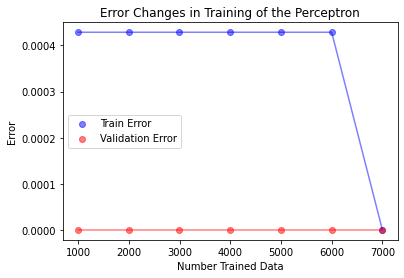

Train Accuracy = 1.0
Validation Accuracy = 1.0

alpha = 100


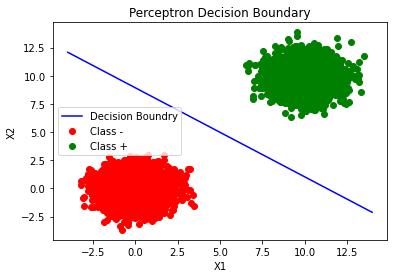

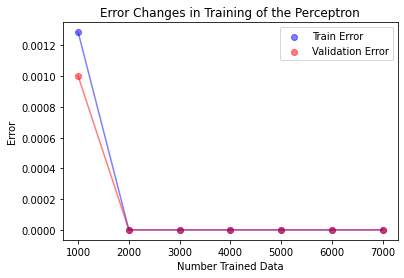

Train Accuracy = 1.0
Validation Accuracy = 1.0


In [24]:
for alpha in [1e-05, 0.01, 0.1, 1, 100]:
  print("====================================\n")
  print(f"alpha = {alpha}")
  perceptron = Perceptron(
                          alpha=alpha, degree = 1,
                          activation_function=ActivationFunctions.sign,
                          )

  perceptron.train(
      X_train = ls_dataset.X_train(),
      y_train = ls_dataset.Y_train(),
      X_validation = ls_dataset.X_validation(),
      y_validation = ls_dataset.Y_validation(),
      epochs = 1
  )

  perceptron.show_decision_boundry(ls_dataset.train())
  perceptron.show_error_values()

### Activation Function


t = -5


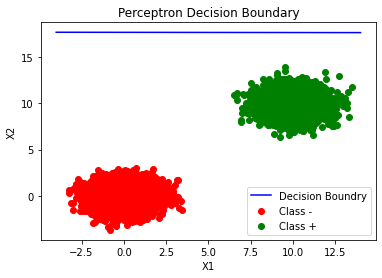

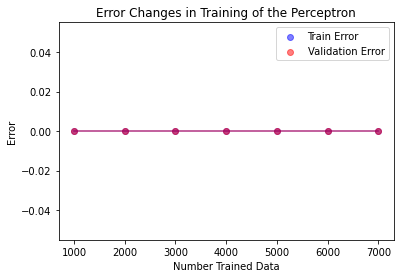

Train Accuracy = 1.0
Validation Accuracy = 1.0

t = 0


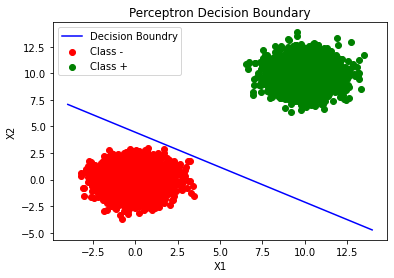

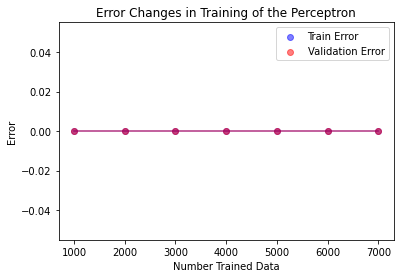

Train Accuracy = 1.0
Validation Accuracy = 1.0

t = 5


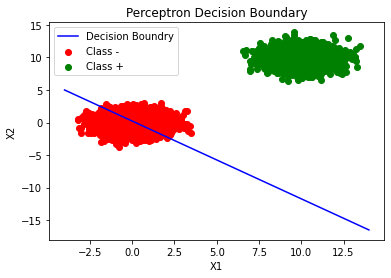

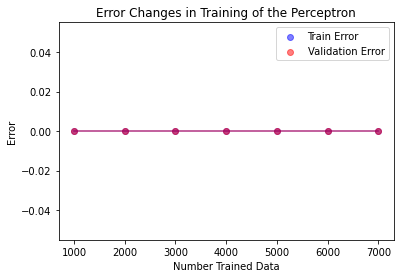

Train Accuracy = 1.0
Validation Accuracy = 1.0


In [25]:
for t in [-5, 0, +5]:
  print("====================================\n")
  print(f"t = {t}")
  perceptron = Perceptron(
                          alpha=0.1, degree = 1,
                          activation_function=ActivationFunctions.generate_step(t=t),
                          )

  perceptron.train(
      X_train = ls_dataset.X_train(),
      y_train = ls_dataset.Y_train(),
      X_validation = ls_dataset.X_validation(),
      y_validation = ls_dataset.Y_validation(),
      epochs = 1
  )

  perceptron.show_decision_boundry(ls_dataset.train())
  perceptron.show_error_values()

## Adaline

### Learning Rate


alpha = 1e-08


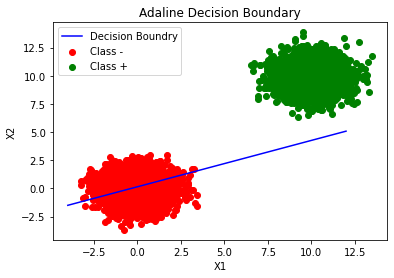

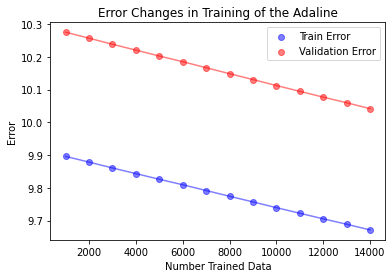

Train Accuracy = 0.7747142857142857
Validation Accuracy = 0.773

alpha = 1e-05


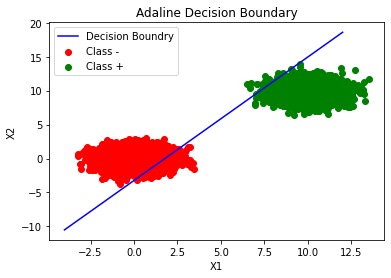

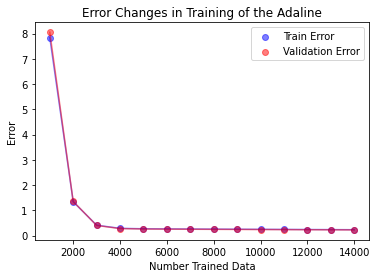

Train Accuracy = 0.9657142857142857
Validation Accuracy = 0.969

alpha = 0.0001


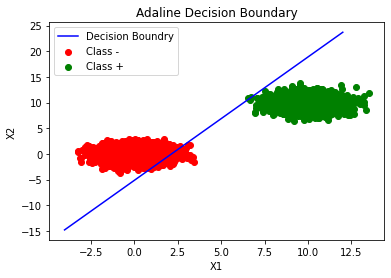

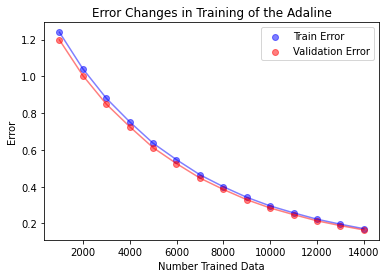

Train Accuracy = 0.9885714285714285
Validation Accuracy = 0.988

alpha = 0.001


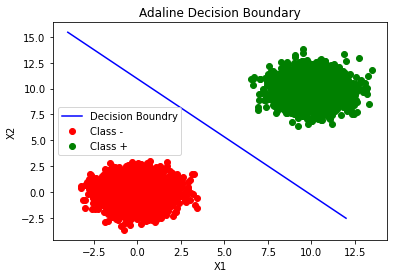

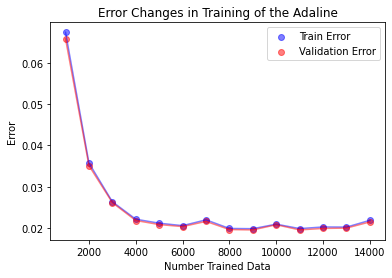

Train Accuracy = 1.0
Validation Accuracy = 1.0

alpha = 0.01


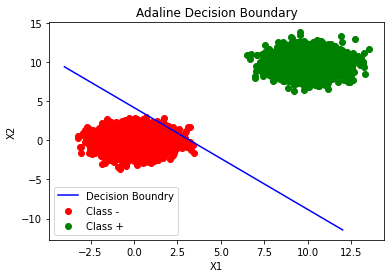

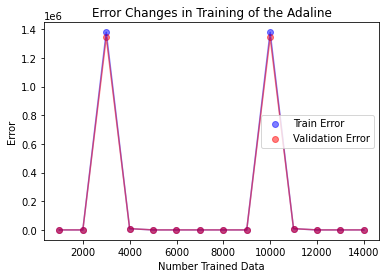

Train Accuracy = 0.9978571428571429
Validation Accuracy = 0.999


In [29]:
for alpha in [1e-08, 1e-05, 1e-04, 1e-03, 0.01]:
  print("====================================\n")
  print(f"alpha = {alpha}")
  adaline = Adaline(
                    alpha=alpha, degree = 1,
                    activation_function=ActivationFunctions.identity
                    )

  adaline.train(
      X_train = ls_dataset.X_train(),
      y_train = ls_dataset.Y_train(),
      X_validation = ls_dataset.X_validation(),
      y_validation = ls_dataset.Y_validation(),
      epochs = 2
  )

  adaline.show_decision_boundry(ls_dataset.train())
  adaline.show_error_values()

### Activation Function


Activation Function = Identity


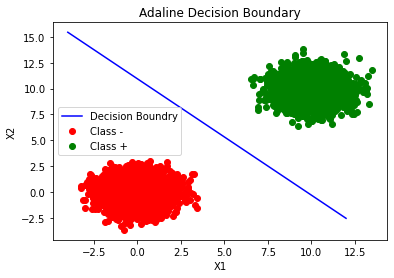

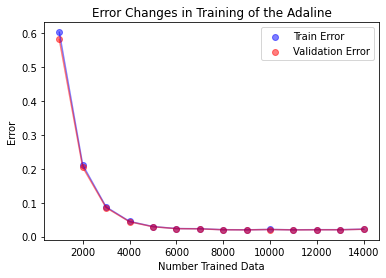

Train Accuracy = 1.0
Validation Accuracy = 1.0

Activation Function = Sigmoid


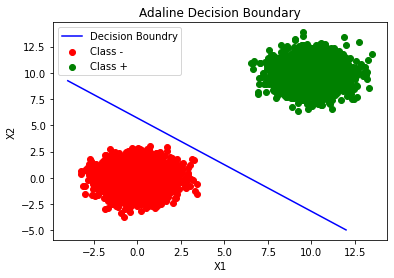

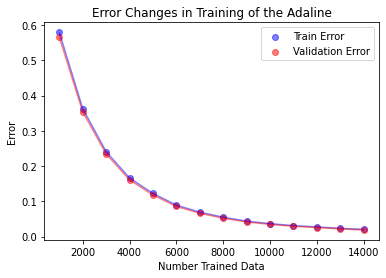

Train Accuracy = 1.0
Validation Accuracy = 1.0

Activation Function = Tanh


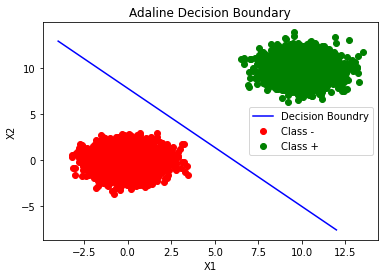

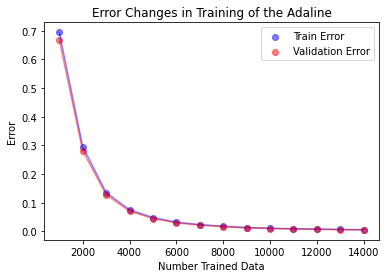

Train Accuracy = 1.0
Validation Accuracy = 1.0


In [34]:
for name, activation_function in zip(["Identity", "Sigmoid", "Tanh"]
                                     , [ActivationFunctions.identity,
                                        ActivationFunctions.bipolar_sigmoid,
                                        ActivationFunctions.tanh]):
  print("====================================\n")
  print(f"Activation Function = {name}")
  adaline = Adaline(
                    alpha=1e-03, degree = 1,
                    activation_function=activation_function
                    )

  adaline.train(
      X_train = ls_dataset.X_train(),
      y_train = ls_dataset.Y_train(),
      X_validation = ls_dataset.X_validation(),
      y_validation = ls_dataset.Y_validation(),
      epochs = 2
  )

  adaline.show_decision_boundry(ls_dataset.train())
  adaline.show_error_values()

# Expriments (Part 5)

## Perceptron

### Learning Rate


alpha = 1e-05


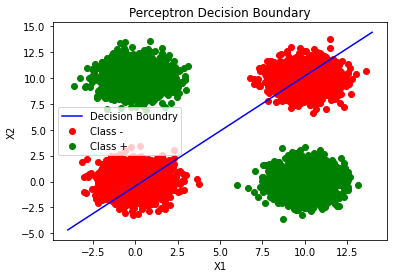

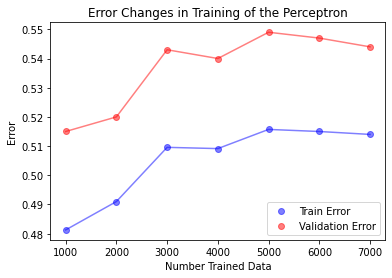

Train Accuracy = 0.4167142857142857
Validation Accuracy = 0.417

alpha = 0.01


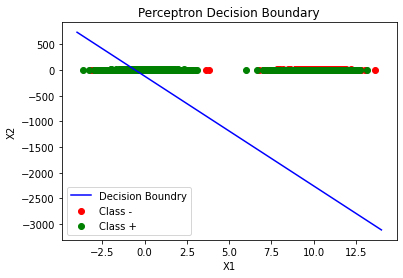

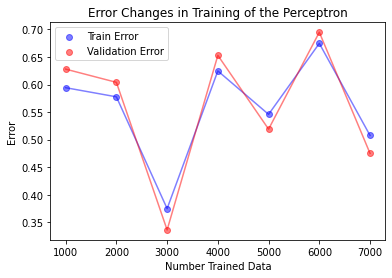

Train Accuracy = 0.6414285714285715
Validation Accuracy = 0.651

alpha = 0.1


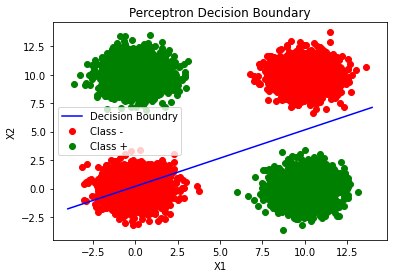

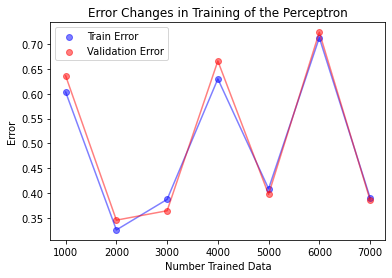

Train Accuracy = 0.217
Validation Accuracy = 0.222

alpha = 1


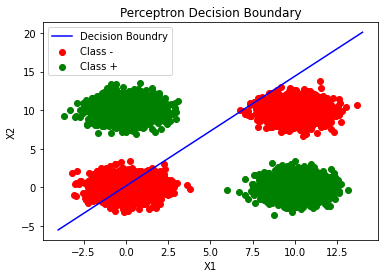

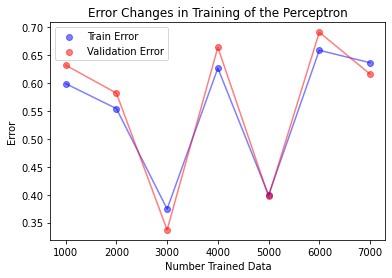

Train Accuracy = 0.7285714285714285
Validation Accuracy = 0.731

alpha = 100


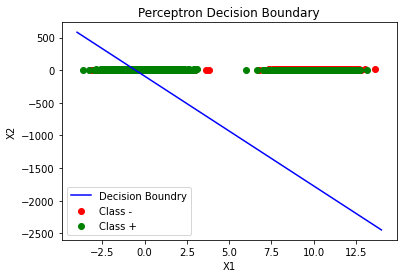

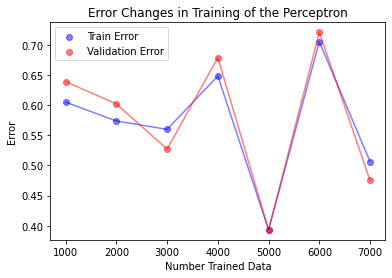

Train Accuracy = 0.6422857142857142
Validation Accuracy = 0.652


In [36]:
for alpha in [1e-05, 0.01, 0.1, 1, 100]:
  print("====================================\n")
  print(f"alpha = {alpha}")
  perceptron = Perceptron(
                          alpha=alpha, degree = 1,
                          activation_function=ActivationFunctions.sign,
                          )

  perceptron.train(
      X_train = xor_dataset.X_train(),
      y_train = xor_dataset.Y_train(),
      X_validation = xor_dataset.X_validation(),
      y_validation = xor_dataset.Y_validation(),
      epochs = 1
  )

  perceptron.show_decision_boundry(xor_dataset.train())
  perceptron.show_error_values()

### Activation Function


t = -5


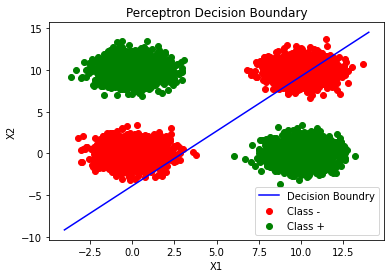

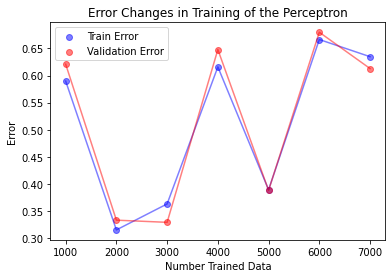

Train Accuracy = 0.7227142857142858
Validation Accuracy = 0.721

t = 0


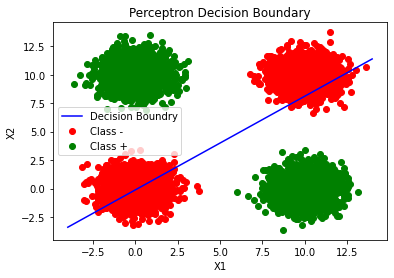

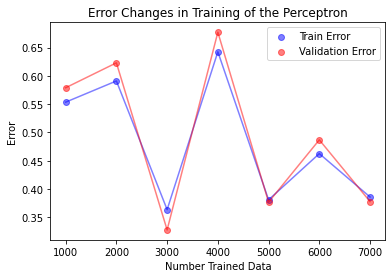

Train Accuracy = 0.307
Validation Accuracy = 0.304

t = 5


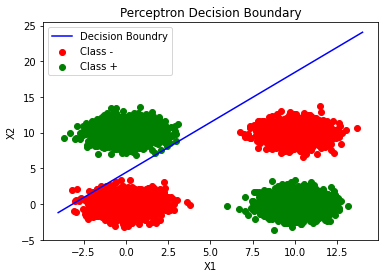

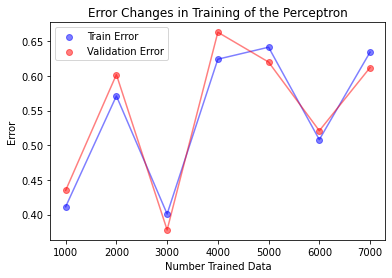

Train Accuracy = 0.7312857142857143
Validation Accuracy = 0.732


In [37]:
for t in [-5, 0, +5]:
  print("====================================\n")
  print(f"t = {t}")
  perceptron = Perceptron(
                          alpha=0.1, degree = 1,
                          activation_function=ActivationFunctions.generate_step(t=t),
                          )

  perceptron.train(
      X_train = xor_dataset.X_train(),
      y_train = xor_dataset.Y_train(),
      X_validation = xor_dataset.X_validation(),
      y_validation = xor_dataset.Y_validation(),
      epochs = 1
  )

  perceptron.show_decision_boundry(xor_dataset.train())
  perceptron.show_error_values()

## Adaline

### Learning Rate


alpha = 1e-08


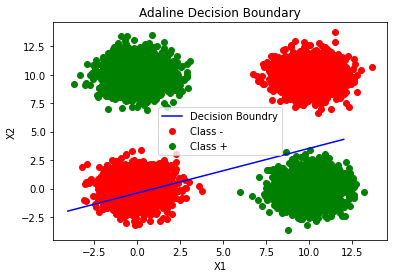

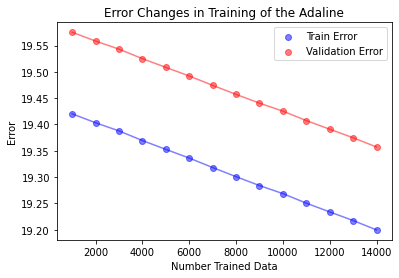

Train Accuracy = 0.6725714285714286
Validation Accuracy = 0.676

alpha = 1e-05


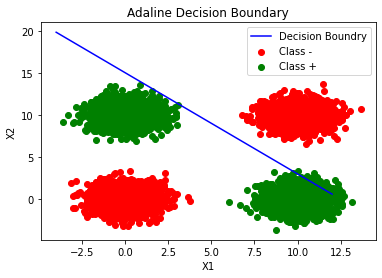

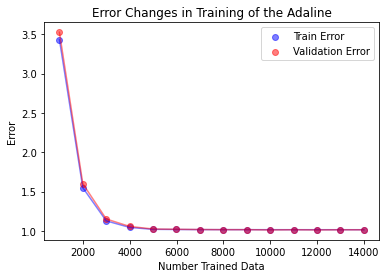

Train Accuracy = 0.0
Validation Accuracy = 0.0

alpha = 0.0001


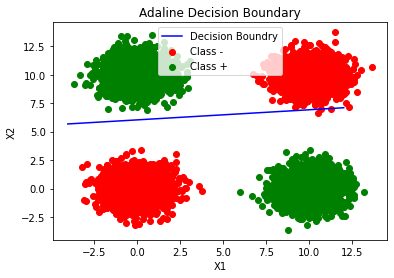

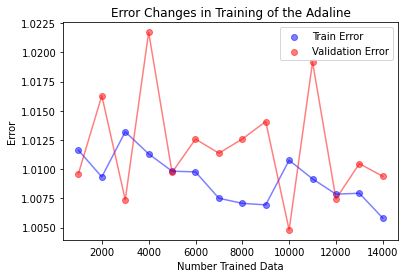

Train Accuracy = 0.999
Validation Accuracy = 0.998

alpha = 0.001


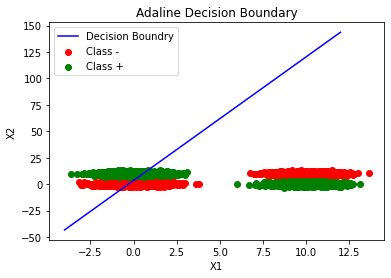

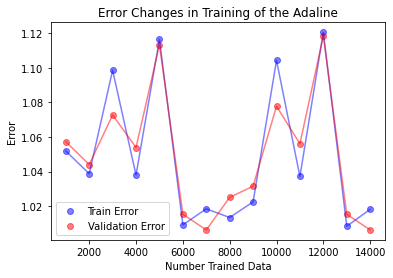

Train Accuracy = 0.6975714285714286
Validation Accuracy = 0.69

alpha = 0.01


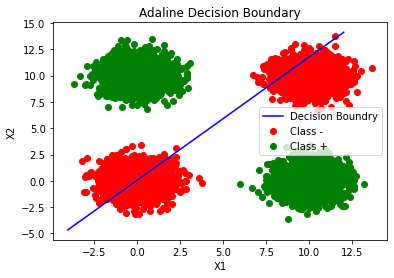

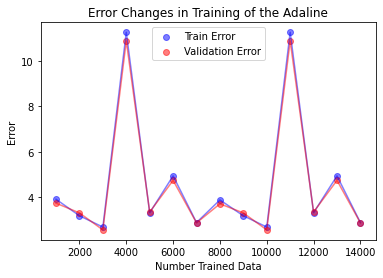

Train Accuracy = 0.6881428571428572
Validation Accuracy = 0.699


In [38]:
for alpha in [1e-08, 1e-05, 1e-04, 1e-03, 0.01]:
  print("====================================\n")
  print(f"alpha = {alpha}")
  adaline = Adaline(
                    alpha=alpha, degree = 1,
                    activation_function=ActivationFunctions.identity
                    )

  adaline.train(
      X_train = xor_dataset.X_train(),
      y_train = xor_dataset.Y_train(),
      X_validation = xor_dataset.X_validation(),
      y_validation = xor_dataset.Y_validation(),
      epochs = 2
  )

  adaline.show_decision_boundry(xor_dataset.train())
  adaline.show_error_values()

### Activation Function


Activation Function = Identity


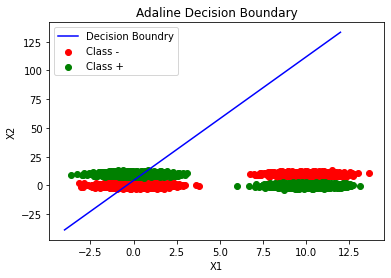

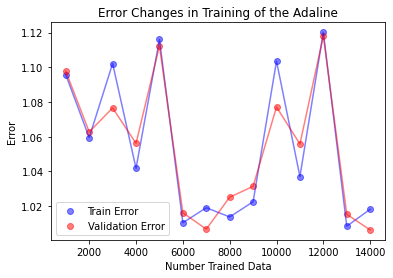

Train Accuracy = 0.674
Validation Accuracy = 0.676

Activation Function = Sigmoid


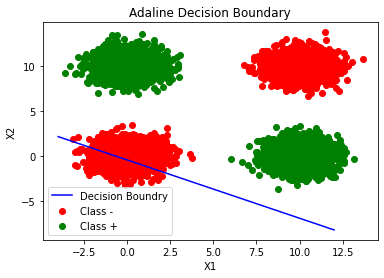

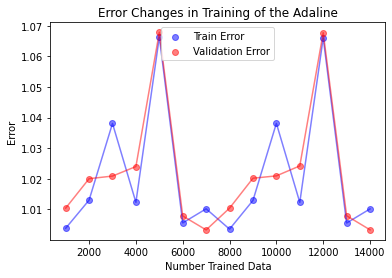

Train Accuracy = 0.6768571428571428
Validation Accuracy = 0.672

Activation Function = Tanh


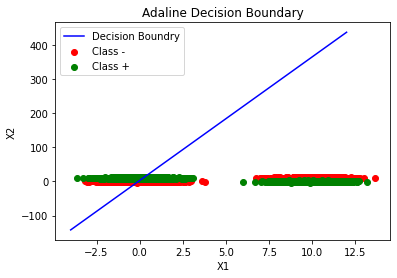

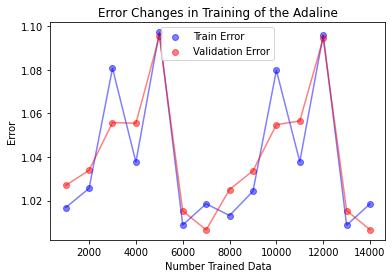

Train Accuracy = 0.7424285714285714
Validation Accuracy = 0.732


In [39]:
for name, activation_function in zip(["Identity", "Sigmoid", "Tanh"]
                                     , [ActivationFunctions.identity,
                                        ActivationFunctions.bipolar_sigmoid,
                                        ActivationFunctions.tanh]):
  print("====================================\n")
  print(f"Activation Function = {name}")
  adaline = Adaline(
                    alpha=1e-03, degree = 1,
                    activation_function=activation_function
                    )

  adaline.train(
      X_train = xor_dataset.X_train(),
      y_train = xor_dataset.Y_train(),
      X_validation = xor_dataset.X_validation(),
      y_validation = xor_dataset.Y_validation(),
      epochs = 2
  )

  adaline.show_decision_boundry(xor_dataset.train())
  adaline.show_error_values()

# Expriments (Part 6)

## Perceptron

### Learning Rate


alpha = 1e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in sqrt


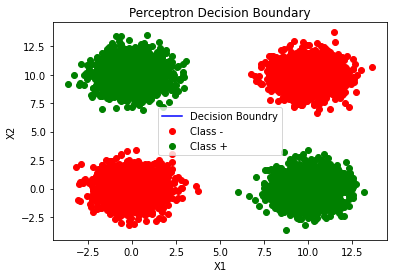

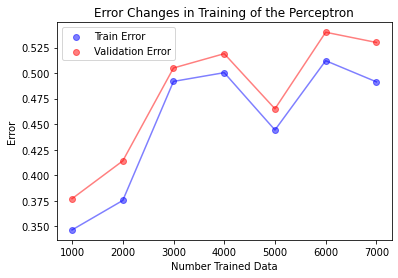

Train Accuracy = 0.6784285714285714
Validation Accuracy = 0.69

alpha = 0.01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in sqrt


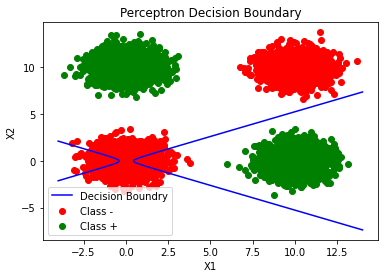

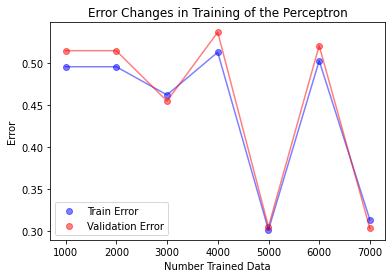

Train Accuracy = 0.38042857142857145
Validation Accuracy = 0.368

alpha = 0.1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in sqrt


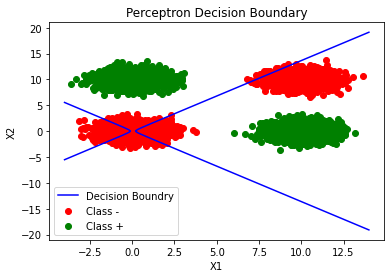

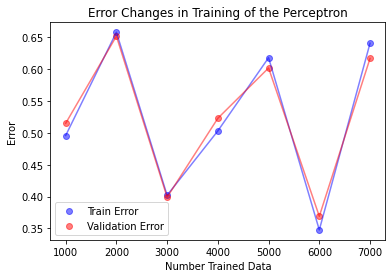

Train Accuracy = 0.7074285714285714
Validation Accuracy = 0.721

alpha = 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in sqrt


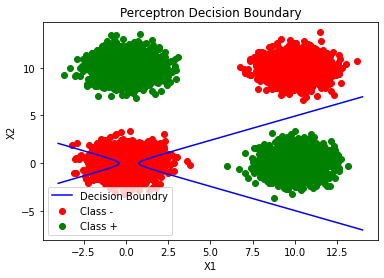

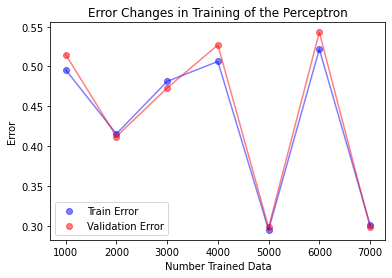

Train Accuracy = 0.3984285714285714
Validation Accuracy = 0.389

alpha = 100


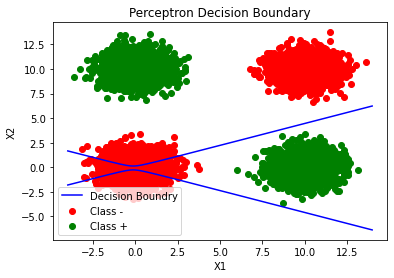

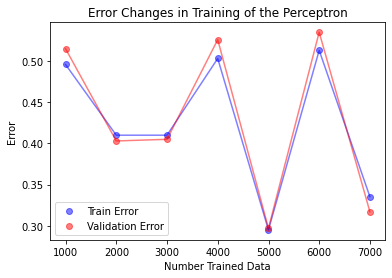

Train Accuracy = 0.34014285714285714
Validation Accuracy = 0.319


In [40]:
for alpha in [1e-05, 0.01, 0.1, 1, 100]:
  print("====================================\n")
  print(f"alpha = {alpha}")
  perceptron = Perceptron(
                          alpha=alpha, degree = 2,
                          activation_function=ActivationFunctions.sign,
                          )

  perceptron.train(
      X_train = xor_dataset.X_train(),
      y_train = xor_dataset.Y_train(),
      X_validation = xor_dataset.X_validation(),
      y_validation = xor_dataset.Y_validation(),
      epochs = 1
  )

  perceptron.show_decision_boundry(xor_dataset.train())
  perceptron.show_error_values()

### Activation Function


t = -5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in sqrt


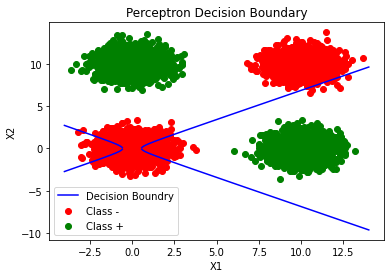

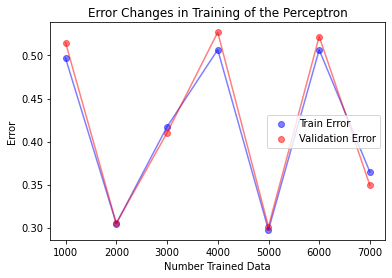

Train Accuracy = 0.28485714285714286
Validation Accuracy = 0.275

t = 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in sqrt


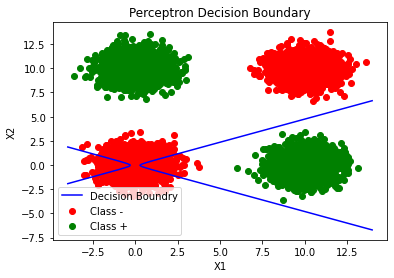

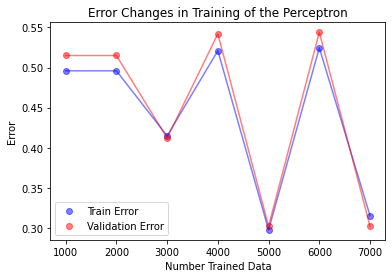

Train Accuracy = 0.37857142857142856
Validation Accuracy = 0.367

t = 5


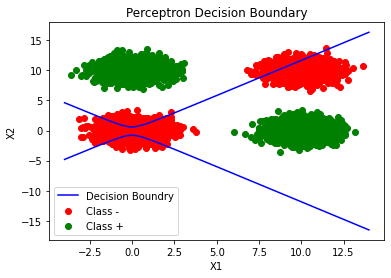

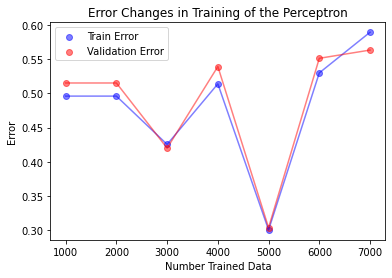

Train Accuracy = 0.685
Validation Accuracy = 0.693


In [42]:
for t in [-5, 0, +5]:
  print("====================================\n")
  print(f"t = {t}")
  perceptron = Perceptron(
                          alpha=0.1, degree = 2,
                          activation_function=ActivationFunctions.generate_step(t=t),
                          )

  perceptron.train(
      X_train = xor_dataset.X_train(),
      y_train = xor_dataset.Y_train(),
      X_validation = xor_dataset.X_validation(),
      y_validation = xor_dataset.Y_validation(),
      epochs = 1
  )

  perceptron.show_decision_boundry(xor_dataset.train())
  perceptron.show_error_values()

## Adaline

### Learning Rate


alpha = 1e-08


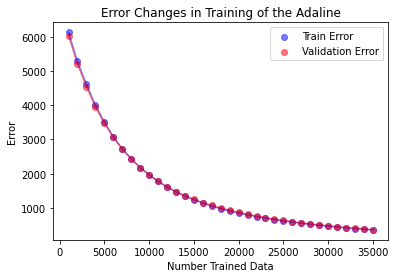

Train Accuracy = 0.43485714285714283
Validation Accuracy = 0.437

alpha = 1e-05


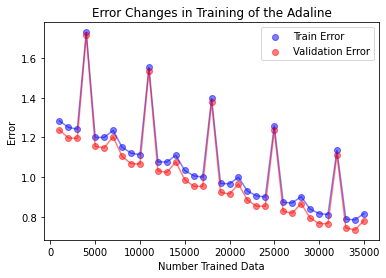

Train Accuracy = 0.4524285714285714
Validation Accuracy = 0.432

alpha = 0.0001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in add


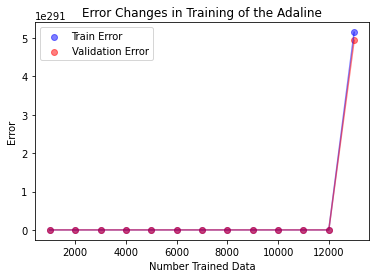

Train Accuracy = 0.0
Validation Accuracy = 0.0

alpha = 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in matmul


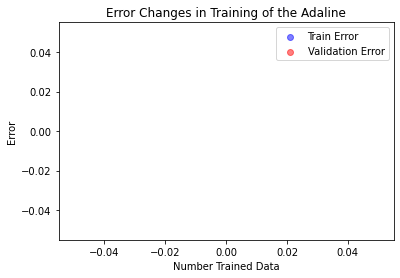

Train Accuracy = 0.0
Validation Accuracy = 0.0

alpha = 0.01


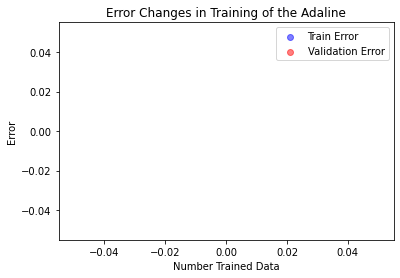

Train Accuracy = 0.0
Validation Accuracy = 0.0


In [45]:
for alpha in [1e-08, 1e-05, 1e-04, 1e-03, 0.01]:
  print("====================================\n")
  print(f"alpha = {alpha}")
  adaline = Adaline(
                    alpha=alpha, degree = 2,
                    activation_function=ActivationFunctions.identity
                    )

  adaline.train(
      X_train = xor_dataset.X_train(),
      y_train = xor_dataset.Y_train(),
      X_validation = xor_dataset.X_validation(),
      y_validation = xor_dataset.Y_validation(),
      epochs = 5
  )

  adaline.show_decision_boundry(xor_dataset.train())
  adaline.show_error_values()

### Activation Function


Activation Function = Identity


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in matmul


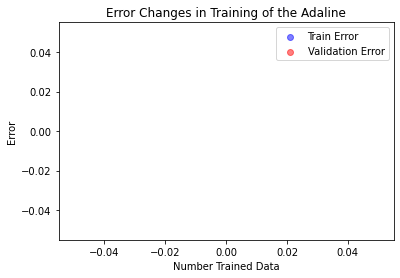

Train Accuracy = 0.0
Validation Accuracy = 0.0

Activation Function = Sigmoid


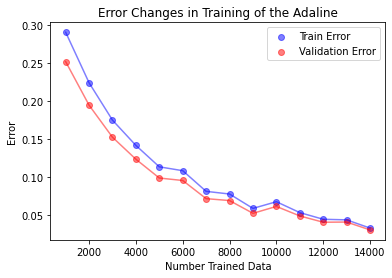

Train Accuracy = 0.5022857142857143
Validation Accuracy = 0.487

Activation Function = Tanh


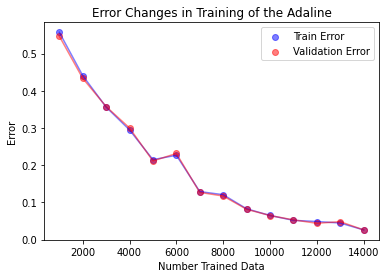

Train Accuracy = 0.49514285714285716
Validation Accuracy = 0.484


In [46]:
for name, activation_function in zip(["Identity", "Sigmoid", "Tanh"]
                                     , [ActivationFunctions.identity,
                                        ActivationFunctions.bipolar_sigmoid,
                                        ActivationFunctions.tanh]):
  print("====================================\n")
  print(f"Activation Function = {name}")
  adaline = Adaline(
                    alpha=1e-03, degree = 2,
                    activation_function=activation_function
                    )

  adaline.train(
      X_train = xor_dataset.X_train(),
      y_train = xor_dataset.Y_train(),
      X_validation = xor_dataset.X_validation(),
      y_validation = xor_dataset.Y_validation(),
      epochs = 2
  )

  adaline.show_decision_boundry(xor_dataset.train())
  adaline.show_error_values()